In [1]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import warnings
import numpy as np
import matplotlib.pyplot as plt
import json
# %matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
warnings.filterwarnings('ignore')


dataset_path = '../ia3/asl_alphabet_train/'

# Create data generator
IMG_WIDTH = 200
IMG_HEIGHT = 200
BATCH_SIZE = 64

print(tf.config.list_physical_devices('GPU'))

2023-05-10 15:51:22.921650: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-05-10 15:51:26.514779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:51:26.540401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-10 15:51:26.540637: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # normalize pixel values to [0,1]
    shear_range=0.2,  # apply shear transformation
    zoom_range=0.2,  # apply zoom transformation
    horizontal_flip=True,
    validation_split=0.2)  # flip images horizontally

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training')  # generate training dataset

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation')  # generate validating dataset

Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.


In [4]:
labels = {value: key for key, value in train_generator.class_indices.items()}

# Save labels to file
json.dump(labels, open('labels.json', 'w'))

In [6]:
# Load pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze some layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(29, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
    
# Compile model
optimizer = Adam(learning_rate=1e-4)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the file path for saving the model
filepath = "output.{epoch:02d}-{val_loss:.2f}.h5"

# Define a callback to save the model every epoch and keep the best one
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model with the checkpoint callback
initial_epoch = 0 # Set initial epoch
best_model_path = "best_model.h5" # Set best model path
latest_checkpoint_path = "latest_checkpoint.h5" # Set latest checkpoint path

# Check if there's a latest checkpoint file
if os.path.isfile(latest_checkpoint_path):
    # Load the weights of the latest checkpoint file into the model
    model.load_weights(latest_checkpoint_path)
    # Get the epoch number of the latest checkpoint file
    latest_checkpoint_epoch = int(latest_checkpoint_path.split('.')[1].split('-')[0])
    # Set the initial epoch to the epoch number of the latest checkpoint file + 1
    initial_epoch = latest_checkpoint_epoch + 1

# Train the model with the checkpoint callback starting from the initial epoch
history = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint], initial_epoch=initial_epoch)


Epoch 1/5


2023-05-10 15:55:04.757138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-05-10 15:55:10.564229: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-10 15:55:13.429831: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-10 15:55:16.908262: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x33d3bf80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-10 15:55:16.908305: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2023-05-10 15:55:16.928313: I

1088/1088 [==============================] - ETA: 0s - loss: 0.6961 - accuracy: 0.8123

2023-05-10 16:10:18.699213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1.15809, saving model to output.01-1.16.h5
1088/1088 [==============================] - 1146s 1s/step - loss: 0.6961 - accuracy: 0.8123 - val_loss: 1.1581 - val_accuracy: 0.6769
Epoch 2/5
1088/1088 [==============================] - ETA: 0s - loss: 0.2522 - accuracy: 0.9279
Epoch 2: val_loss improved from 1.15809 to 1.05260, saving model to output.02-1.05.h5
1088/1088 [==============================] - 1082s 994ms/step - loss: 0.2522 - accuracy: 0.9279 - val_loss: 1.0526 - val_accuracy: 0.7091
Epoch 3/5
1088/1088 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9460
Epoch 3: val_loss did not improve from 1.05260
1088/1088 [==============================] - 1087s 999ms/step - loss: 0.1817 - accuracy: 0.9460 - val_loss: 1.0707 - val_accuracy: 0.7183
Epoch 4/5
1088/1088 [==============================] - ETA: 0s - loss: 0.1374 - accuracy: 0.9602
Epoch 4: val_loss did not improve from 1.05260
1088/1088 [========================

In [9]:
# Unfreeze some layers in the base model
for layer in model.layers[:50]:
    layer.trainable = True

# Train the model with the checkpoint callback starting from the initial epoch
history = model.fit(train_generator, epochs=5, validation_data=val_generator, callbacks=[checkpoint], initial_epoch=initial_epoch)

Epoch 1/5


2023-05-10 17:50:54.234401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1088/1088 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9736
Epoch 1: val_loss did not improve from 1.05260
1088/1088 [==============================] - 1076s 988ms/step - loss: 0.0876 - accuracy: 0.9736 - val_loss: 1.0852 - val_accuracy: 0.7383
Epoch 2/5
  93/1088 [=>............................] - ETA: 13:11 - loss: 0.0756 - accuracy: 0.9777

KeyboardInterrupt: 

In [10]:
tf.keras.models.save_model(model, "output")

INFO:tensorflow:Assets written to: output/assets


INFO:tensorflow:Assets written to: output/assets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.0/992.0 kB 7.4 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip


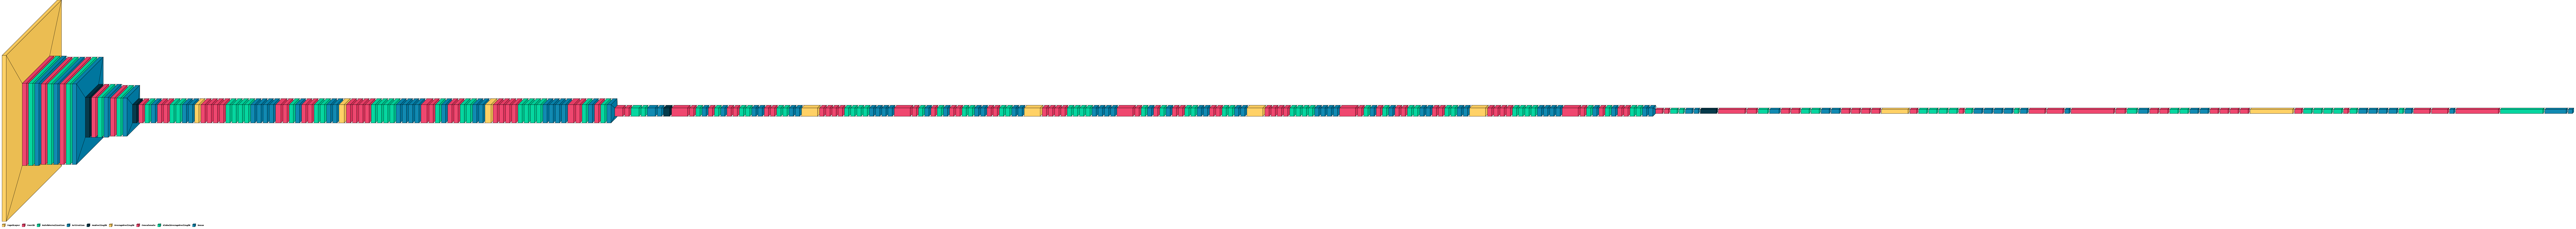

In [11]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True) # without custom font